# Evolving sentiment in Crypto markets
James Rockey (jrockey2)

Kareem Benaissa (kareem2)

### This project explores the relationship between cryptocurrency sentiment through tweets

This is done in the following steps:

1. Calculate sentiment of tweets with BERT model pretrained with financial sentiment

Model: https://huggingface.co/ProsusAI/finbert

Tweets dataset: https://www.kaggle.com/code/codeblogger/bitcoin-sentiment-analysis

Tweets are preprocessed before they are fed into the model.

The FinBERT model outputs percentage confidence in three following sentiment categories: ['positive', 'negative', 'neutral']

2. After sentiment scores are calculated for every tweet, we compare the effect of sentiment on predictive power of LSTMs. 

For the purposes of this research we want to explore intraday sentiment. So, we collected tweets from 15 random days in February 2021 and March 2021, and for each of these days we calculated sentiment in 10 minute increments. We then considered different sized sequences of 10 minutes to predict the next 1 or 2 sequences. We compare LSTM's prediction of price, volume, and other features, using these features as a baseline, with its performance when sentiment and weighted average sentiment are included in trainging.

## Step 1: Calculating Sentiment

In our dataset, the 'text' column contains the content of the tweet. We preprocess this text and use our BERT model to calculate sentiment

In [73]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request




In [74]:
df = pd.read_csv('datasets/Bitcoin_tweets.csv', sep=',', header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48583 entries, 0 to 48582
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         48581 non-null  object
 1   user_location     28272 non-null  object
 2   user_description  45263 non-null  object
 3   user_created      48583 non-null  object
 4   user_followers    48583 non-null  int64 
 5   user_friends      48583 non-null  int64 
 6   user_favourites   48583 non-null  int64 
 7   user_verified     48583 non-null  bool  
 8   date              48583 non-null  object
 9   text              48583 non-null  object
 10  hashtags          38416 non-null  object
 11  source            47685 non-null  object
 12  is_retweet        48583 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 4.2+ MB


In [75]:
# Load the model
MODEL = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [83]:
# helper functions
def get_labels(): 
    labels=[]

    # This is for another BERT model that we tried:
    # mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
    # with urllib.request.urlopen(mapping_link) as f:
    #     html = f.read().decode('utf-8').split("\n")
    #     csvreader = csv.reader(html, delimiter='\t')
    # labels = [row[1] for row in csvreader if len(row) > 1]

    # This is for the FinBERT model:
    labels = ['positive', 'negative', 'neutral']
    return labels


def preprocess(text):
    '''
    Preprocess text (username and link placeholders)
    '''    
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


def process_tweet(text: str):
    '''
    Calculates sentiment scores for the given text
    '''
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

# Modified print_scores function to return values instead of printing
def get_sentiment_scores(scores):
    labels = get_labels()
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    return {labels[ranking[i]]: np.round(float(scores[ranking[i]]), 4) for i in range(scores.shape[0])}

# Function to apply to each row
def analyze_sentiment(row):
    '''
    Takes in row from dataframe and returns a series of sentiment scores
    Used in df.apply()
    '''
    text = row['text']
    scores = process_tweet(text)
    labels = get_labels()
    sentiment_scores = get_sentiment_scores(scores)
    
    return pd.Series([sentiment_scores.get('positive', 0), 
                      sentiment_scores.get('neutral', 0), 
                      sentiment_scores.get('negative', 0)])

def print_scores(scores, labels):
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l} {np.round(float(s), 4)}")


### Example use of sentiment model

In [84]:
text = '''New Listing Announcement: Swaprol is  listed on major exchange Bibox.

Swaprol is listed on https://t.co/2YckIcXHT5… https://t.co/tf9dWrxAyp''' # example tweet

scores = process_tweet(text)
labels = get_labels()
print_scores(scores, labels)

1) neutral 0.9583
2) positive 0.023
3) negative 0.0188


### Apply to dataset
Note, this may take several hours. Data with sentiment scores already calculated is found in this file: sentiment_added_data.csv

In [86]:
from tqdm import tqdm
tqdm.pandas()

print(len(df))
# df[['positive', 'neutral', 'negative']] = df.progress_apply(analyze_sentiment, axis=1)
# df.to_csv('calculated_sentiment.csv')



48583


# ____________________________________________________________________________
# Step 2: Analyzing Sentiment

Here, we explore how sentiment using the bert model effects LSTM prediction

### Calculate 10 minute sentiment scores for each day in dataset

The sentiment score for a given day is found by taking an average of the ['positive', 'negative', 'neutral'] columns in our dataset during a 10-mintue interval. 

For each trading day, we group tweets into 10-minute intervals starting at 12:00:00 am until 11:59:59 pm. 

We also explore how the "reach" of a tweet affects daily sentiment by calculating a weighted average over the number of followers twitter user.

If a 10-minute slice is missing tweets, we give each column equal weight

In [56]:
'''
The following functions calculate the weighted average 
and average sentiment scores for a group from the dataframe.

Input: group: from the df.groupby() function

Output: series of weighted average and average sentiment scores

'''

def weighted_average(group):
    weighted_positive = (group['positive'] * group['user_followers']).sum()
    weighted_neutral = (group['neutral'] * group['user_followers']).sum()
    weighted_negative = (group['negative'] * group['user_followers']).sum()
    total_followers = np.sum(group['user_followers'])
    
    if total_followers == 0:
        return pd.Series({
            'weighted_avg_positive': 1/3,
            'weighted_avg_neutral': 1/3,
            'weighted_avg_negative': 1/3
        })
    return pd.Series({
        'weighted_avg_positive': weighted_positive / total_followers,
        'weighted_avg_neutral': weighted_neutral / total_followers,
        'weighted_avg_negative': weighted_negative / total_followers
    })

def average(group):
    avg_positive = group['positive'].mean()
    avg_neutral = group['neutral'].mean()
    avg_negative = group['negative'].mean()

    total_followers = np.sum(group['user_followers'])
    
    if total_followers == 0:
        # print('INVALID TOTAL' + str(count))
        return pd.Series({
            'weighted_avg_positive': 1/3,
            'weighted_avg_neutral': 1/3,
            'weighted_avg_negative': 1/3
        })
    return pd.Series({
        'avg_positive': avg_positive,
        'avg_neutral': avg_neutral,
        'avg_negative': avg_negative
    })


### Process Daily Tweet Data:

Hour chunks are included if there occurs at least one tweet during that hour.
Each hour chunk is split into six 10 minute intervals, and average sentiment score is calculated for each interval

For missing 10 minute intervals, average sentiment score is weighted equally across all ['positive', 'negative', 'neutral'] columns


In [67]:
# '''
# This function takes in a dataframe for a single day 
# and returns dataframe filtered into 10 minute sentiment intervals by the date
# '''
from datetime import datetime
def process_day_data(day_df, interval_size='10T', default_values=None, avg_func = weighted_average):
    # Ensure 'date' column is in datetime format
    day_df['date'] = pd.to_datetime(day_df['date'])

    # Extract the date part as a string
    day_str = day_df['date'].dt.date.iloc[0].isoformat()

    # Identify hours with at least one tweet
    active_hours = day_df['date'].dt.hour.unique()

    # Create a DataFrame to hold the final result
    processed_data = pd.DataFrame()

    # Set default values for missing data points
    default_values = default_values if default_values is not None else 1/3

    # Iterate through each active hour and process data
    for hour in active_hours:
        # Create a datetime object for the start of the hour
        start_time_str = f"{day_str} {hour:02d}:00:00"
        start_time = datetime.fromisoformat(start_time_str)
        end_time = start_time + pd.Timedelta(hours=1) - pd.Timedelta(seconds=1)


        # Create date range for this hour
        date_range = pd.date_range(start=start_time, end=end_time, freq=interval_size)

        # Filter the DataFrame for the current hour and group by interval
        hour_df = day_df[(day_df['date'] >= start_time) & (day_df['date'] <= end_time)]
        grouped_data = hour_df.groupby(pd.Grouper(key='date', freq=interval_size)).apply(weighted_average).reset_index()

        # Reindex to ensure all intervals are present
        grouped_data.set_index('date', inplace=True)
        grouped_data = grouped_data.reindex(date_range)

        # Fill missing data with default values
        grouped_data.fillna(default_values, inplace=True)

        # Add the processed data for this hour to the final DataFrame
        processed_data = pd.concat([processed_data, grouped_data.reset_index()])

    # Reset index and rename the date column
    processed_data.reset_index(drop=True, inplace=True)
    processed_data.rename(columns={'index': 'date'}, inplace=True)
    return processed_data


### This function returns preprocessed sentiment data in the form of hourly chunks of 10-minute intervald

For each day, we consider hourly windows. If a tweet occurred within an hour window, for that given hour we split into six 10-minute intervals

In [68]:
def get_processed_twitter_data(avg_func):

    sentiment_df = pd.read_csv('datasets/tweets_with_sentiment.csv')

    # information to keep: user_followers, date, positive, neutral, negative
    sentiment_df = sentiment_df[['user_followers', 'date', 'positive', 'neutral', 'negative']]
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

    # group by days
    day_tweets_df = sentiment_df.groupby(sentiment_df['date'].dt.date)

    day_data = []

    for day, group_data in day_tweets_df:
        data = process_day_data(group_data, avg_func=avg_func) # process data for each day (fill in missing interval data)
        day_data.append(data)

    # print(day_data.keys())
    day_tweets_df = pd.concat(day_data, ignore_index=True)

    return day_tweets_df


### Grouping our tweets with sentiment with Bitcoin minute dataset

In [69]:
def  get_merged_datasets(avg_func = weighted_average):
    day_tweets_df = get_processed_twitter_data(avg_func)

    btc_minute_df = pd.read_csv('datasets/BTC-2021min.csv', sep=',', header=0)
    btc_minute_df['date'] = pd.to_datetime(btc_minute_df['date'])

    combined_data = pd.merge(day_tweets_df, btc_minute_df, on='date', how='inner')
    return combined_data

combined_data = get_merged_datasets()
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1752 non-null   datetime64[ns]
 1   weighted_avg_positive  1752 non-null   float64       
 2   weighted_avg_neutral   1752 non-null   float64       
 3   weighted_avg_negative  1752 non-null   float64       
 4   unix                   1752 non-null   int64         
 5   symbol                 1752 non-null   object        
 6   open                   1752 non-null   float64       
 7   high                   1752 non-null   float64       
 8   low                    1752 non-null   float64       
 9   close                  1752 non-null   float64       
 10  Volume BTC             1752 non-null   float64       
 11  Volume USD             1752 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory u

### Creating sequences

In [60]:
'''
This function takes in pandas dataframe and returns nonoverlapping sequences

data: np ndarray of the values of a set of columns

lookback: number of rows to look back on
m: number of rows after lookback to include in sequence

X: where len(X) = lookback 
y: where len(y) = m
'''

def create_sequences(data, lookback: int, m = 1, output_features = [1, 2, 3], is_overlapping = False):
    X, y = [], []
    hop_size = lookback + m
    if is_overlapping:
        hop_size = 1
    for i in range(0, len(data) - (lookback+m), hop_size):
        # for given window, get only the features columns
        X_seq = data[i:(i+lookback)] # start at first sequence
        y_seq = data[i+lookback:i+lookback+m, output_features]

        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

### Creating Sequences for LSTM

We are training our LSTM with sequences of 10-minute interval data.

The first method we tried created hourly predictions, where the first 50 minutes of an hour predicted the last 10 minutes

However after viewing the structure of the data, we noticed that there were noticable segments of days with tweets, separated from days with no tweets. 

So, our second method creates overlapping sequences from segments containing at least one tweet every hour. 


In [43]:
from sklearn.preprocessing import MinMaxScaler

def find_gaps(df, gap_threshold):
    df = df.sort_values('date')
    df['time_diff'] = df['date'].diff()
    gap_threshold = pd.Timedelta(gap_threshold)
    gaps = df['time_diff'] > gap_threshold

    gap_indices = np.where(gaps)[0]
    return gap_indices


def get_nonoverlapping_sequences(lookback_size=5, prediction_size=1, features = ['close', 'avg_negative'], output_features = [0]):
    combined_data = get_merged_datasets()

    # TODO: change to your desired features
    features = ['close', 'avg_negative']       # 'weighted_avg_positive', 'weighted_avg_neutral', 'weighted_avg_negative', 
    output_features = [0] # only predict close
    lookback_size = 5 # 
    prediction_size = 1


    scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_features = scaler.fit_transform(combined_data[features].values)


    days = []
    num_days = combined_data.groupby(combined_data['date'].dt.date).ngroups
    for i in range(0, num_days):
        # get data for that day
        num_rows = scaled_features.shape[0] // num_days
        day_data = scaled_features[i*num_rows:(i+1)*num_rows]

        X, y = create_sequences(day_data, lookback_size, prediction_size, output_features)
        days.append((X, y))
    # split days up into 80% training and 20% testing
    training_data = days[:int(len(days)*0.8)]
    testing_data = days[int(len(days)*0.8):]

    X_train = np.concatenate([data[0] for data in training_data])
    y_train = np.concatenate([data[1] for data in training_data])

    X_test = np.concatenate([data[0] for data in testing_data])
    y_test = np.concatenate([data[1] for data in testing_data]) 

    return X_train, y_train, X_test, y_test


def get_overlapping_sequences(lookback_size=5, prediction_size=1, features = ['close', 'avg_negative'], output_features = [0]):
    combined_data = get_merged_datasets()

    # TODO: change to your desired features
    features = ['close', 'avg_negative']       # 'weighted_avg_positive', 'weighted_avg_neutral', 'weighted_avg_negative', 
    output_features = [0] # only predict close
    lookback_size = 5 # 
    prediction_size = 1

    # Scale the entire dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(combined_data[features].values)

    # Find gaps and extract segments from scaled data
    gap_indices = find_gaps(combined_data, '1H')
    scaled_segments = np.split(scaled_data, gap_indices)

    # Create overlapping sequences from segments
    segments = []
    for segment in scaled_segments:
        X, y = create_sequences(segment, lookback_size, prediction_size, output_features, is_overlapping=True)
        segments.append((X, y))


    big_X = np.concatenate([X for X, _ in segments], axis=0)
    big_y = np.concatenate([y for _, y in segments], axis=0)

    # split days up into 80% training and 20% testing
    X_train = big_X[:int(len(big_X)*0.8)]
    y_train = big_y[:int(len(big_y)*0.8)]
    X_test = big_X[int(len(big_X)*0.8):]
    y_test = big_y[int(len(big_y)*0.8):]


    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = get_overlapping_sequences()


# LSTM Model

In [44]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

In [45]:

lookback_size = 5 # 
prediction_size = 1
features = ['close', 'avg_negative']
output_features = [0]

X_train, y_train, X_test, y_test = get_nonoverlapping_sequences(lookback_size, prediction_size, features, output_features)


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(lookback_size, len(features))))
model.add(LSTM(50))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

### Training Model

In [46]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], batch_size=32)

Epoch 1/100
8/8 [==============================] - 2s 71ms/step - loss: 0.1492 - val_loss: 0.2777
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0415 - val_loss: 0.0214
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0217 - val_loss: 0.0111
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0401
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0256
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0109
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0113
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0148
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0127
Epoch 11/100
8/8 [==========

In [184]:
model.evaluate(X_test, y_test)


2/2 [==============================] - 0s 8ms/step - loss: 0.0115


0.01150317769497633

# Model with sentiment included performance

In [18]:
model.evaluate(X_test, y_test)
# 0.00015919399447739124 < 0.00015837745741009712


2/2 [==============================] - 0s 2ms/step - loss: 6.5089e-04


0.0006508909282274544

In [19]:
model.evaluate(X_test, y_test)


2/2 [==============================] - 0s 2ms/step - loss: 6.5089e-04


0.0006508909282274544

In [23]:
model.evaluate(X_test, y_test)


2/2 [==============================] - 0s 2ms/step - loss: 6.5089e-04


0.0006508909282274544

## Extra:
1. Preprocessing step: show 3 tweets before and after processing (table)
2. Sentiment Scores: Highest positive tweet, highest negative tweet, (table)
3. Sentiment x Bitcoin price: plot of sentiment vs bitcoin price
4. LSTM Model Parameters (table)
5. LSTM prediction of test data (plot)
6. LSTM Evaluation metrics, with sentiment and without (table)

In [15]:
# 1. Preprocessing step: show 3 tweets before and after processing (table)
tweet = '''Bitcoin's value is skyrocketing! Check out the latest 
stats at http://bit.ly/btcStats @cryptoguru'''

# Preprocess the tweet
processed_tweet = preprocess(tweet)
print(processed_tweet)

Bitcoin's value is skyrocketing! Check out the latest 
stats at http @user


In [55]:
# 2. Sentiment Scores: Highest positive tweet, highest negative tweet, (table)
tweets_with_sentiment = pd.read_csv('datasets/tweets_with_sentiment.csv')
# tweets_with_sentiment.info()

top_positive = tweets_with_sentiment.nlargest(3, 'positive')
top_negative = tweets_with_sentiment.nlargest(3, 'negative')
top_neutral = tweets_with_sentiment.nlargest(3, 'neutral')

print(1, top_positive.iloc[0]['text'])
print(2,top_positive.iloc[1]['text'])
print(3,top_positive.iloc[2]['text'])
print(4, top_negative.iloc[0]['text'])
print(5, top_negative.iloc[1]['text'])
print(6, top_negative.iloc[2]['text'])
print(7, top_neutral.iloc[0]['text'])
print(8, top_neutral.iloc[1]['text'])
print(9, top_neutral.iloc[2]['text'])

1 The share price of @Nasdaq-listed #CryptoMining company @canaanio has surged, thanks to improved revenue visibility… https://t.co/avxPkcdFaP
2 On the other hand, there is an immediate expectation of #bitcoin having greatly increased demand in the very near f… https://t.co/Di0AavsVq9
3 $ADA is showing great signs for continuation.
$adaeth still has room to the upside &gt;35%
$adabtc confirmed the beako… https://t.co/f242NahIjb
4 #Cryptocurrencies slid in Asian trading hours on Mon, with #Bitcoin dropping more than 5%, as investors took profit… https://t.co/6o2OOQaPcj
5 #Bitcoin fell below US$52,000 per coin, and fell by more than US$5,500 from its daily high, or nearly 10%.#BTC
6 #Bitcoin slips from the all-time high record of 58,354 USD within a Day. 
#etherium  also fell 7% to 1,798 USD wher… https://t.co/xkHECMHr04
7 New Listing Announcement: Swaprol is  listed on major exchange Bibox.

Swaprol is listed on https://t.co/2YckIcXHT5… https://t.co/tf9dWrxAyp
8 Bought some $FTT and $su

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1752 non-null   datetime64[ns]
 1   weighted_avg_positive  1752 non-null   float64       
 2   weighted_avg_neutral   1752 non-null   float64       
 3   weighted_avg_negative  1752 non-null   float64       
 4   unix                   1752 non-null   int64         
 5   symbol                 1752 non-null   object        
 6   open                   1752 non-null   float64       
 7   high                   1752 non-null   float64       
 8   low                    1752 non-null   float64       
 9   close                  1752 non-null   float64       
 10  Volume BTC             1752 non-null   float64       
 11  Volume USD             1752 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory u

interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

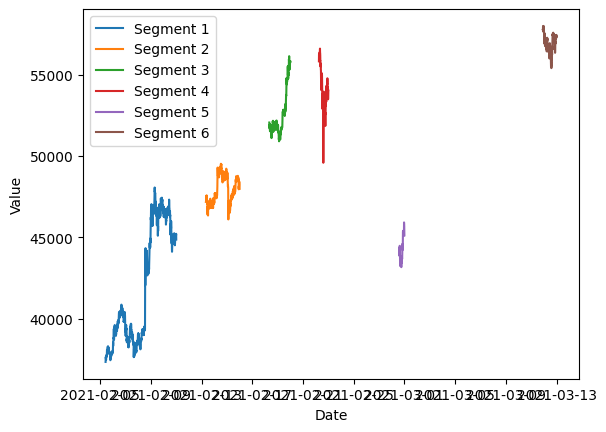

In [72]:
# 3. Sentiment x Bitcoin price: plot of sentiment vs bitcoin price

def get_segments(data, gap_threshold = '1H', features = ['close', 'avg_negative']):
    cpy = data[features]
    # print(cpy['avg_neutral'])
    # convert dataframe to ndarray
    ndarray = cpy.to_numpy()
    gap_indices = find_gaps(data, gap_threshold=gap_threshold)
    segments = np.split(ndarray, gap_indices)
    return segments, gap_indices


# choose features
features = ['close', 'weighted_avg_positive', 'weighted_avg_negative', 'weighted_avg_neutral']

combined_data = get_merged_datasets(weighted_average)
combined_data.info()

combined_data['date'] = pd.to_datetime(combined_data['date'])
segments, gap_indices = get_segments(combined_data, gap_threshold='1H', features=features)

# get all times from rows in combined_data until gap_indices, and then to the end
times = combined_data['date'].to_numpy()
times = np.split(times, gap_indices)

# include slider bar for user to choose which segment to view
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interact_manual

@interact
def show_tweets(i=(0, len(segments) - 1)):
    plt.clf()  # Clear the previous plot
    segment = segments[i]
    time = times[i]

    # Ensure time is in numpy datetime64 format
    time = np.array(time, dtype='datetime64')

    # Get the indices that would sort the time array
    sorted_indices = np.argsort(time)

    # Apply the sorting indices to both the time and price arrays
    sorted_time = time[sorted_indices]
    sorted_price = segment[:, 0][sorted_indices]

    plt.plot(sorted_time, sorted_price, label='BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('BTC Price vs Time')
    plt.legend()
    plt.show()

    plt.plot(sorted_time, segment[:, 1][sorted_indices], label='Positive Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Positive Sentiment vs Time')
    plt.legend()
    plt.show()

    # do the same for negative and neutral sentiment
    plt.plot(sorted_time, segment[:, 2][sorted_indices], label='Negative Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Negative Sentiment vs Time')
    plt.legend()
    plt.show()

    plt.plot(sorted_time, segment[:, 3][sorted_indices], label='Neutral Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Neutral Sentiment vs Time')
    plt.legend()
    plt.show()

    # plt.plot(sorted_time, segment[:, 2][sorted_indices], label='Negative Sentiment')
    # plt.plot(sorted_time, segment[:, 3][sorted_indices], label='Neutral Sentiment')

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interact_manual

# I assume segments and times are defined as before and are available here

def plot_all_segments(segments, times):
    plt.clf()  # Clear the previous plot

    for i in range(len(segments)):
        segment = segments[i]
        time = times[i]

        # Ensure time is in numpy datetime64 format
        time = np.array(time, dtype='datetime64')

        # Get the indices that would sort the time array
        sorted_indices = np.argsort(time)

        # Apply the sorting indices to both the time and price arrays
        sorted_time = time[sorted_indices]
        sorted_price = segment[:, 0][sorted_indices]

        # Plot the sorted time and prices
        plt.plot(sorted_time, sorted_price, label=f'Segment {i+1}')

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Call the function to plot all segments
plot_all_segments(segments, times)



84


/var/folders/qq/m89p4_x94zx6v_zssvtmrx6c0000gn/T/ipykernel_62313/3440171119.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_day_data['date'] = pd.to_datetime(first_day_data['date'])


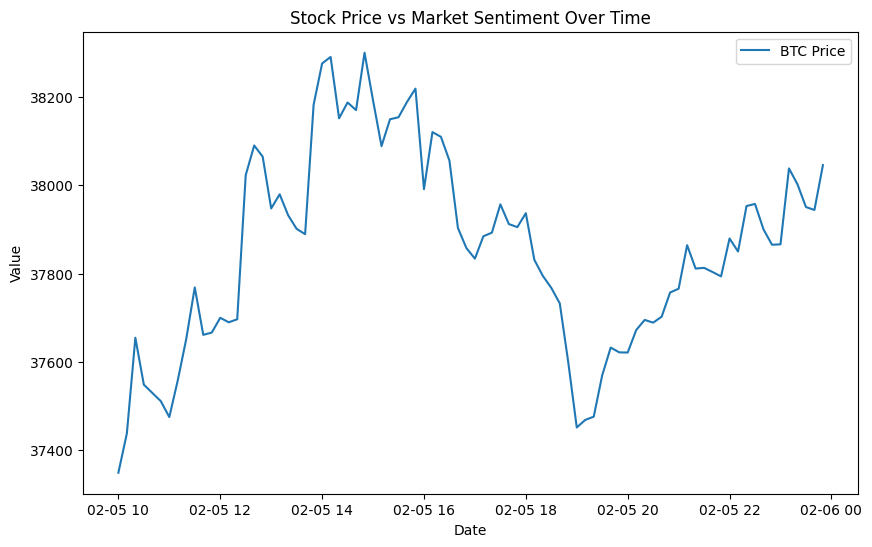

In [90]:
# plot how tweets occur over the first day
import matplotlib.pyplot as plt
import pandas as pd

# 3. Sentiment x Bitcoin price: plot of sentiment vs bitcoin price
combined_data = get_merged_datasets()
# Sort the DataFrame by date just in case it's not already sorted
combined_data = combined_data.sort_values('date')

# Get the first date
first_date = combined_data['date'].dt.date.iloc[0]

# Filter the DataFrame to only include rows with the first date
first_day_data = combined_data[combined_data['date'].dt.date == first_date]
print(len(first_day_data))

first_day_data['date'] = pd.to_datetime(first_day_data['date'])
# Plotting
plt.figure(figsize=(10,6))
plt.plot(first_day_data['date'], first_day_data['close'], label='BTC Price')
# plt.plot(df['date'], df['sentiment_score'], label='Sentiment Score')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Stock Price vs Market Sentiment Over Time')
plt.legend()
plt.show()
